# LASSO with SMOTE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from sympy import Matrix
from IPython.display import display, Math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaled = MinMaxScaler()
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
from imblearn.over_sampling import SMOTE

In [3]:
def prec_mat(y,yhat):
    
    y_true = len(y[y==1])
    y_false = len(y[y==-1])
    
    yhat_true = len(yhat[yhat==1])
    yhat_false = len(yhat[yhat==-1])
    
    error = y - yhat
    
    inc_true = len(error[error==2])
    inc_false = len(error[error==-2])
    
    cor_true = y_true - inc_true
    cor_false = y_false - inc_false
    
    y_mat = np.array([[cor_true/y_true,inc_false/y_false],[inc_true/y_true,cor_false/y_false]])
  
    return y_mat

def ista_solve_hot(A,d,la_array):

    max_iter = 10**5
    tol = 10**(-4)
    tau = 1/np.linalg.norm(A,2)**2
    n = A.shape[1]
    w = np.zeros((n,1))
    num_lam = len(la_array)
    X = np.zeros((n, num_lam))
    
    for i, each_lambda in enumerate(la_array):
        for j in range(max_iter):
            z = w - np.reshape(tau*(A.T@(np.reshape(A@w,d.shape)-d)),w.shape)
            w_old = w
            w = np.sign(z) * np.clip(np.abs(z)-tau*each_lambda/2, 0, np.inf)
            X[:, i:i+1] = w
            if np.linalg.norm(w - w_old) < tol:
                break
    return X

## Load and Process Data

In [4]:
data = pd.read_csv('nasa_train.csv')

### Scale Features and Implement SMOTE

In [5]:
y_pre = data.Hazardous.values.reshape(-1,1)
X_pre = data.drop(['Hazardous'],axis=1).values
X_pre = scaled.fit_transform(X_pre)
sm = SMOTE(random_state = 2) 
X, y = sm.fit_sample(X_pre, y_pre.ravel()) 

## All Feature LASSO

### Without Cross Validation

In [8]:
reg = np.geomspace(10**(-6),100,15)

W = ista_solve_hot(X,y,reg)

error_reg = np.zeros(len(reg))

for k in range(len(reg)):

    y_hat = np.reshape(np.sign(X@W[:,k]),y.shape)
    error_reg[k] = np.count_nonzero(y-y_hat)/len(y)
    
ind_best = np.argmin(error_reg)
w = W[:,ind_best]
    
display(Matrix(np.round(w,2)))

Matrix([
[-4.67],
[-7.88],
[ 0.15],
[ 0.13],
[-0.52],
[-4.04],
[ 4.26],
[ 1.06],
[ 1.78],
[ 0.13],
[ 0.36],
[-0.01],
[-2.27],
[  1.8],
[ 0.03],
[ 1.71],
[-0.93],
[ 0.06],
[-2.88]])

In [9]:
reg_best = reg[ind_best]
print('Best Regularizer =',np.round(reg_best,3))

Best Regularizer = 1.931


In [10]:
yhat = np.reshape(np.sign(X_pre@w),y_pre.shape)
err = y_pre - yhat
error = np.count_nonzero(err)/len(err)
print('The error using all features is',np.round(error*100,1),'%')
conf_mat = prec_mat(y_pre,yhat)
display(Matrix(np.round(conf_mat*100,1)))

The error using all features is 13.9 %


Matrix([
[97.2, 16.1],
[ 2.8, 83.9]])

Based on the confusion matrix, it can be seen the model is able to accurately predict that an asteroid is hazardous but cannot as accurately predict that an asteroid is not hazardous.

## Feature Selection with LASSO

### Initial Guess

In [11]:
delete_feat = np.delete(np.arange(X.shape[1]),[0,5,1])
X_3 = np.delete(X,delete_feat,axis=1)
X_3_pre = np.delete(X_pre,delete_feat,axis=1)

W = ista_solve_hot(X_3,y,reg)

error_reg = np.zeros(len(reg))

for j in range(len(reg)):

    y_hat = np.reshape(np.sign(X_3@W[:,j]),y.shape)
    error_reg[j] = np.count_nonzero(y-y_hat)/len(y)

ind_best = np.argmin(error_reg)
w_3 = W[:,ind_best]

display(Matrix(np.round(w_3,2)))

Matrix([
[-0.01],
[15.88],
[-2.81]])

These weights are almost exactly the same as the Least Sqaured SMOTE intial guess case so similair results are expected.

### Ranking Features

In [9]:
least_feat = np.zeros(X.shape[1],dtype=int)

X_del = copy.copy(X)

for i in range(X.shape[1]):

    W = ista_solve_hot(X_del,y,reg)

    error_reg = np.zeros(len(reg))

    for j in range(len(reg)):

        y_hat = np.reshape(np.sign(X_del@W[:,j]),y.shape)
        error_reg[j] = np.count_nonzero(y-y_hat)/len(y)
    
    ind_best = np.argmin(error_reg)
    w = W[:,ind_best]

    least_feat[i] = np.argmin(abs(w))
    
    X_del = np.delete(X_del,least_feat[i],axis=1)    
    
least_feat = least_feat.tolist()

least_feat_sort = np.zeros(len(least_feat),dtype=int)
least_feat_sort = least_feat_sort.tolist()

least_feat_sort[0] = least_feat[0]  

all_int = list(range(0, X.shape[1]))

all_int.remove(least_feat_sort[0])
    
for i in range(1,len(least_feat)):
    
    least_feat_sort[i] = all_int[least_feat[i]]
    all_int.pop(least_feat[i])
    
best_feat = np.flip(np.array(least_feat_sort))
print('Ranked Features:', best_feat)

Ranked Features: [18  6  0 15  5 12 13  8  1  7 16 10  4  9  2  3 17 14 11]


In [10]:
error = np.zeros(X.shape[1])

for i in range(len(best_feat)):
    
    delete_feat = np.delete(np.arange(X.shape[1]),best_feat[0:i+1])
    X_del = np.delete(X,delete_feat,axis=1)
    X_pre_del = np.delete(X_pre,delete_feat,axis=1)
        
    W = ista_solve_hot(X_del,y,reg)

    error_reg = np.zeros(len(reg))

    for j in range(len(reg)):

        y_hat = np.reshape(np.sign(X_del@W[:,j]),y.shape)
        error_reg[j] = np.count_nonzero(y-y_hat)/len(y)
    
    ind_best = np.argmin(error_reg)
    w = W[:,ind_best]
    y_hat = np.reshape(np.sign(X_pre_del@W[:,j]),y_pre.shape)
    error[i] = np.count_nonzero(y_pre-y_hat)/len(y_pre)

best_comb = np.argmin(error)

### Selection

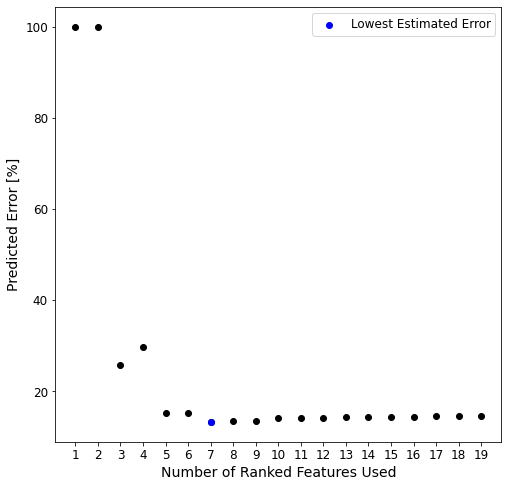

In [11]:
plt.figure(figsize=(8,8))
plt.rc('font', size=12)
plt.scatter(np.arange(0,19)+1,error*100,color='k', marker='o', alpha=1)
plt.scatter(best_comb+1,error[best_comb]*100,color='b', marker='o', alpha=1,label='Lowest Estimated Error')
plt.xlabel('Number of Ranked Features Used',fontsize=14)
plt.xticks(np.arange(0,19)+1)
plt.ylabel('Predicted Error [%]',fontsize=14)
plt.legend(fontsize=12)
plt.show()

Looking at the graph above, the lowest error occurs using the 7 most imporartant features.

## "Final" Training

In [12]:
data.drop(['Est Dia in KM(max)','Relative Velocity km per sec','Miss Dist.(kilometers)','Orbit Uncertainity',
           'Epoch Osculation','Eccentricity','Semi Major Axis','Inclination','Asc Node Longitude','Perihelion Arg',
           'Perihelion Time','Mean Anomaly'],axis=1,inplace=True)

In [13]:
data

,Absolute Magnitude,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Orbital Period,Perihelion Distance,Aphelion Dist,Mean Motion,Hazardous
0,21.6,0.025282,4.634,609.599786,0.808259,2.005764,0.590551,1
1,21.3,0.186935,5.457,425.869294,0.718200,1.497352,0.845330,-1
2,20.3,0.043058,4.557,643.580228,0.950791,1.966857,0.559371,1
3,27.4,0.005512,5.093,514.082140,0.983902,1.527904,0.700277,-1
4,21.6,0.034798,5.154,495.597821,0.967687,1.483543,0.726395,1
...,...,...,...,...,...,...,...,...
4213,26.3,0.040471,6.696,302.474700,0.683367,1.080329,1.190182,-1
4214,20.7,0.121499,3.843,814.019755,0.592216,2.820140,0.442250,-1
4215,23.9,0.019777,5.156,457.179984,0.741558,1.581299,0.787436,-1
4216,22.7,0.059973,4.410,690.054279,0.965760,2.090708,0.521698,-1


In [14]:
y_pre = data.Hazardous.values.reshape(-1,1)
X_final_pre = data.drop(['Hazardous'],axis=1).values
X_final_pre = scaled.fit_transform(X_final_pre)
X_final, y = sm.fit_sample(X_final_pre, y_pre.ravel()) 

In [15]:
W = ista_solve_hot(X_final,y,reg)

error_reg = np.zeros(len(reg))

for j in range(len(reg)):

    y_hat = np.reshape(np.sign(X_final@W[:,j]),y.shape)
    error_reg[j] = np.count_nonzero(y-y_hat)/len(y)

ind_best = np.argmin(error_reg)
w = W[:,ind_best]
display(Matrix(np.round(w,1)))

Matrix([
[ -4.9],
[ -3.8],
[  5.0],
[-13.3],
[  1.9],
[ 13.6],
[ -2.5]])

In [16]:
error_final = np.count_nonzero(y_pre - np.reshape(np.sign(X_final_pre@w),y_pre.shape))/len(y_pre)
print('The error using the 7 most important features is',np.round(error_final*100,1),'%')

The error using the 7 most important features is 13.3 %


In [17]:
yhat = np.reshape(np.sign(X_final_pre@w),y_pre.shape)
conf_mat = prec_mat(y_pre,yhat)
display(Matrix(np.round(conf_mat*100,1)))

Matrix([
[99.1, 15.7],
[ 0.9, 84.3]])

Based on the confusion matrix, it can be seen the model is able to accurately predict that an asteroid is hazardous but cannot as accurately predict that an asteroid is not hazardous.

## Validation

### Remove one Feature

In [18]:
error = np.zeros(X_final.shape[1])

for i in range(X_final.shape[1]):
    
    delete_feat = i
    X_del = np.delete(X_final,delete_feat,axis=1)
    X_del_pre = np.delete(X_final_pre,delete_feat,axis=1)
    
    W = ista_solve_hot(X_del,y,reg)
    
    error_reg = np.zeros(len(reg))

    for j in range(len(reg)):

        y_hat = np.reshape(np.sign(X_del@W[:,j]),y.shape)
        error_reg[j] = np.count_nonzero(y-y_hat)/len(y)

    ind_best = np.argmin(error_reg)
    w_del = W[:,ind_best]
    
    y_hat = np.reshape(np.sign(X_del_pre@w_del),y_pre.shape)
    err = np.count_nonzero(y_pre-y_hat)/len(y_pre)
    error[i] = err

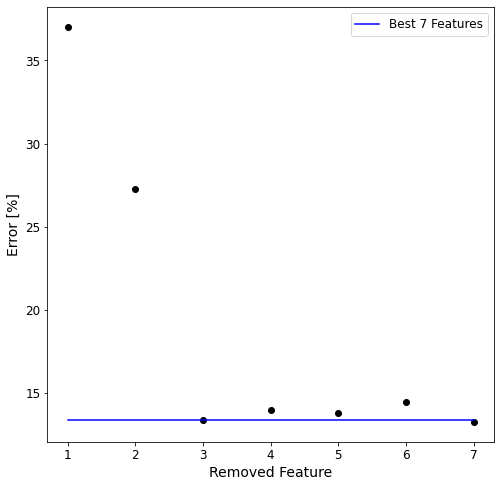

In [19]:
plt.figure(figsize=(8,8))
plt.rc('font', size=12)
plt.scatter(np.arange(X_final.shape[1])+1,error*100,color='k', marker='o', alpha=1)
plt.plot([1,7],[error_final*100,error_final*100],color='b',label='Best 7 Features')
plt.xlabel('Removed Feature',fontsize=14)
plt.xticks(np.arange(7)+1)
plt.ylabel('Error [%]',fontsize=14)
plt.legend()
plt.show()

In [20]:
data.drop(['Mean Motion'],axis=1,inplace=True)

In [21]:
y_pre = data.Hazardous.values.reshape(-1,1)
X_final_pre = data.drop(['Hazardous'],axis=1).values
X_final_pre = scaled.fit_transform(X_final_pre)
X_final, y = sm.fit_sample(X_final_pre, y_pre.ravel()) 

In [22]:
W = ista_solve_hot(X_final,y,reg)

error_reg = np.zeros(len(reg))

for j in range(len(reg)):

    y_hat = np.reshape(np.sign(X_final@W[:,j]),y.shape)
    error_reg[j] = np.count_nonzero(y-y_hat)/len(y)

ind_best = np.argmin(error_reg)
w = W[:,ind_best]
display(Matrix(np.round(w,1)))

Matrix([
[ -4.9],
[ -3.8],
[  2.6],
[-15.2],
[  2.3],
[ 14.7]])

In [23]:
yhat = np.reshape(np.sign(X_final_pre@w),y_pre.shape)
conf_mat = prec_mat(y_pre,yhat)
display(Matrix(np.round(conf_mat*100,1)))

Matrix([
[99.4, 15.7],
[ 0.6, 84.3]])

In [24]:
error_final = np.count_nonzero(y_pre - np.reshape(np.sign(X_final_pre@w),y_pre.shape))/len(y_pre)
print('The error using the 6 most important features is',np.round(error_final*100,1),'%')

The error using the 6 most important features is 13.2 %


In [25]:
error = np.zeros(X_final.shape[1])

for i in range(X_final.shape[1]):
    
    delete_feat = i
    X_del = np.delete(X_final,delete_feat,axis=1)
    X_del_pre = np.delete(X_final_pre,delete_feat,axis=1)
    
    W = ista_solve_hot(X_del,y,reg)
    
    error_reg = np.zeros(len(reg))

    for j in range(len(reg)):

        y_hat = np.reshape(np.sign(X_del@W[:,j]),y.shape)
        error_reg[j] = np.count_nonzero(y-y_hat)/len(y)

    ind_best = np.argmin(error_reg)
    w_del = W[:,ind_best]
    
    y_hat = np.reshape(np.sign(X_del_pre@w_del),y_pre.shape)
    err = np.count_nonzero(y_pre-y_hat)/len(y_pre)
    error[i] = err

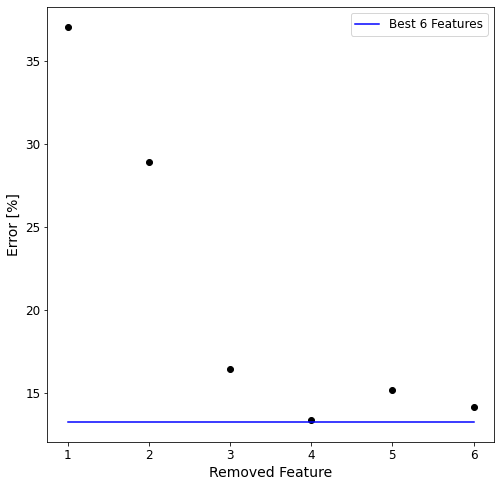

In [26]:
plt.figure(figsize=(8,8))
plt.rc('font', size=12)
plt.scatter(np.arange(X_final.shape[1])+1,error*100,color='k', marker='o', alpha=1)
plt.plot([1,6],[error_final*100,error_final*100],color='b',label='Best 6 Features')
plt.xlabel('Removed Feature',fontsize=14)
plt.xticks(np.arange(6)+1)
plt.ylabel('Error [%]',fontsize=14)
plt.legend()
plt.show()

In [27]:
data.drop(['Orbital Period'],axis=1,inplace=True)

In [28]:
y_pre = data.Hazardous.values.reshape(-1,1)
X_final_pre = data.drop(['Hazardous'],axis=1).values
X_final_pre = scaled.fit_transform(X_final_pre)
X_final, y = sm.fit_sample(X_final_pre, y_pre.ravel()) 

In [29]:
W = ista_solve_hot(X_final,y,reg)

error_reg = np.zeros(len(reg))

for j in range(len(reg)):

    y_hat = np.reshape(np.sign(X_final@W[:,j]),y.shape)
    error_reg[j] = np.count_nonzero(y-y_hat)/len(y)

ind_best = np.argmin(error_reg)
w = W[:,ind_best]
display(Matrix(np.round(w,1)))

Matrix([
[-3.2],
[-3.1],
[ 2.4],
[ 0.7],
[ 3.4]])

In [30]:
yhat = np.reshape(np.sign(X_final_pre@w),y_pre.shape)
conf_mat = prec_mat(y_pre,yhat)
display(Matrix(np.round(conf_mat*100,1)))

Matrix([
[95.6, 15.0],
[ 4.4, 85.0]])

This instance increased the error on the hazardous cases greatly so this will not be done.

### Final Training

In [45]:
data = pd.read_csv('nasa_train.csv')
data.drop(['Est Dia in KM(max)','Relative Velocity km per sec','Miss Dist.(kilometers)','Orbit Uncertainity',
           'Epoch Osculation','Eccentricity','Semi Major Axis','Inclination','Asc Node Longitude','Perihelion Arg',
           'Perihelion Time','Mean Anomaly'],axis=1,inplace=True)
data.drop(['Mean Motion'],axis=1,inplace=True)

In [46]:
y_pre = data.Hazardous.values.reshape(-1,1)
X_final_pre = data.drop(['Hazardous'],axis=1).values

In [34]:
X_final_pre = scaled.fit_transform(X_final_pre)
X_final, y = sm.fit_sample(X_final_pre, y_pre.ravel())

In [35]:
W = ista_solve_hot(X_final,y,reg)

error_reg = np.zeros(len(reg))

for j in range(len(reg)):

    y_hat = np.reshape(np.sign(X_final@W[:,j]),y.shape)
    error_reg[j] = np.count_nonzero(y-y_hat)/len(y)

ind_best = np.argmin(error_reg)
w = W[:,ind_best]
display(Matrix(np.round(w,1)))

Matrix([
[ -4.9],
[ -3.8],
[  2.6],
[-15.2],
[  2.3],
[ 14.7]])

In [37]:
yhat = np.reshape(np.sign(X_final_pre@w),y_pre.shape)
conf_mat = prec_mat(y_pre,yhat)
display(Matrix(np.round(conf_mat*100,1)))

Matrix([
[99.4, 15.7],
[ 0.6, 84.3]])

### Add one Feature

In [38]:
error = []
ind = []

for i in range(X.shape[1]):
    
    if i not in best_feat[:5]:
    
        delete_feat = np.delete(np.arange(0,X.shape[1]),np.hstack((best_feat[:5],np.array([i],dtype=int))))
        X_add = np.delete(X,delete_feat,axis=1)
        X_pre_add = np.delete(X_pre,delete_feat,axis=1)
        
        W = ista_solve_hot(X_add,y,reg)
    
        error_reg = np.zeros(len(reg))

        for j in range(len(reg)):

            y_hat = np.reshape(np.sign(X_add@W[:,j]),y.shape)
            error_reg[j] = np.count_nonzero(y-y_hat)/len(y)

        ind_best = np.argmin(error_reg)
        w_add = W[:,ind_best]
        
        y_hat = np.reshape(np.sign(X_pre_add@w_add),y_pre.shape)
        err = np.count_nonzero(y_pre-y_hat)/len(y_pre)
        error.append( err )
        ind.append(i)

error = np.array(error)
ind = np.array(ind)

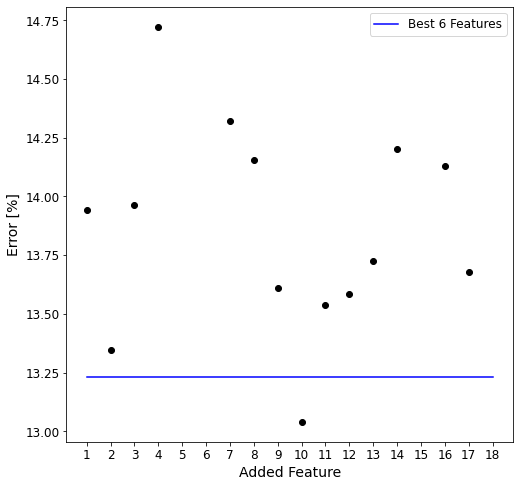

In [39]:
plt.figure(figsize=(8,8))
plt.rc('font', size=12)
plt.scatter(ind,error*100,color='k', marker='o', alpha=1)
plt.plot([1,18],[error_final*100,error_final*100],color='b',label='Best 6 Features')
plt.xlabel('Added Feature',fontsize=14)
plt.xticks(np.arange(18)+1)
plt.ylabel('Error [%]',fontsize=14)
plt.legend()
plt.show()

It can be observed adding any feature to the dataset does not significantly reduce the predicted error. In most cases, adding the feature even increases the expected error. This is consistent with out graph of ranked features and validates the selection of the features.

## Visualization of Chosen Features

In [40]:
data

,Absolute Magnitude,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Orbital Period,Perihelion Distance,Aphelion Dist,Hazardous
0,21.6,0.025282,4.634,609.599786,0.808259,2.005764,1
1,21.3,0.186935,5.457,425.869294,0.718200,1.497352,-1
2,20.3,0.043058,4.557,643.580228,0.950791,1.966857,1
3,27.4,0.005512,5.093,514.082140,0.983902,1.527904,-1
4,21.6,0.034798,5.154,495.597821,0.967687,1.483543,1
...,...,...,...,...,...,...,...
4213,26.3,0.040471,6.696,302.474700,0.683367,1.080329,-1
4214,20.7,0.121499,3.843,814.019755,0.592216,2.820140,-1
4215,23.9,0.019777,5.156,457.179984,0.741558,1.581299,-1
4216,22.7,0.059973,4.410,690.054279,0.965760,2.090708,-1


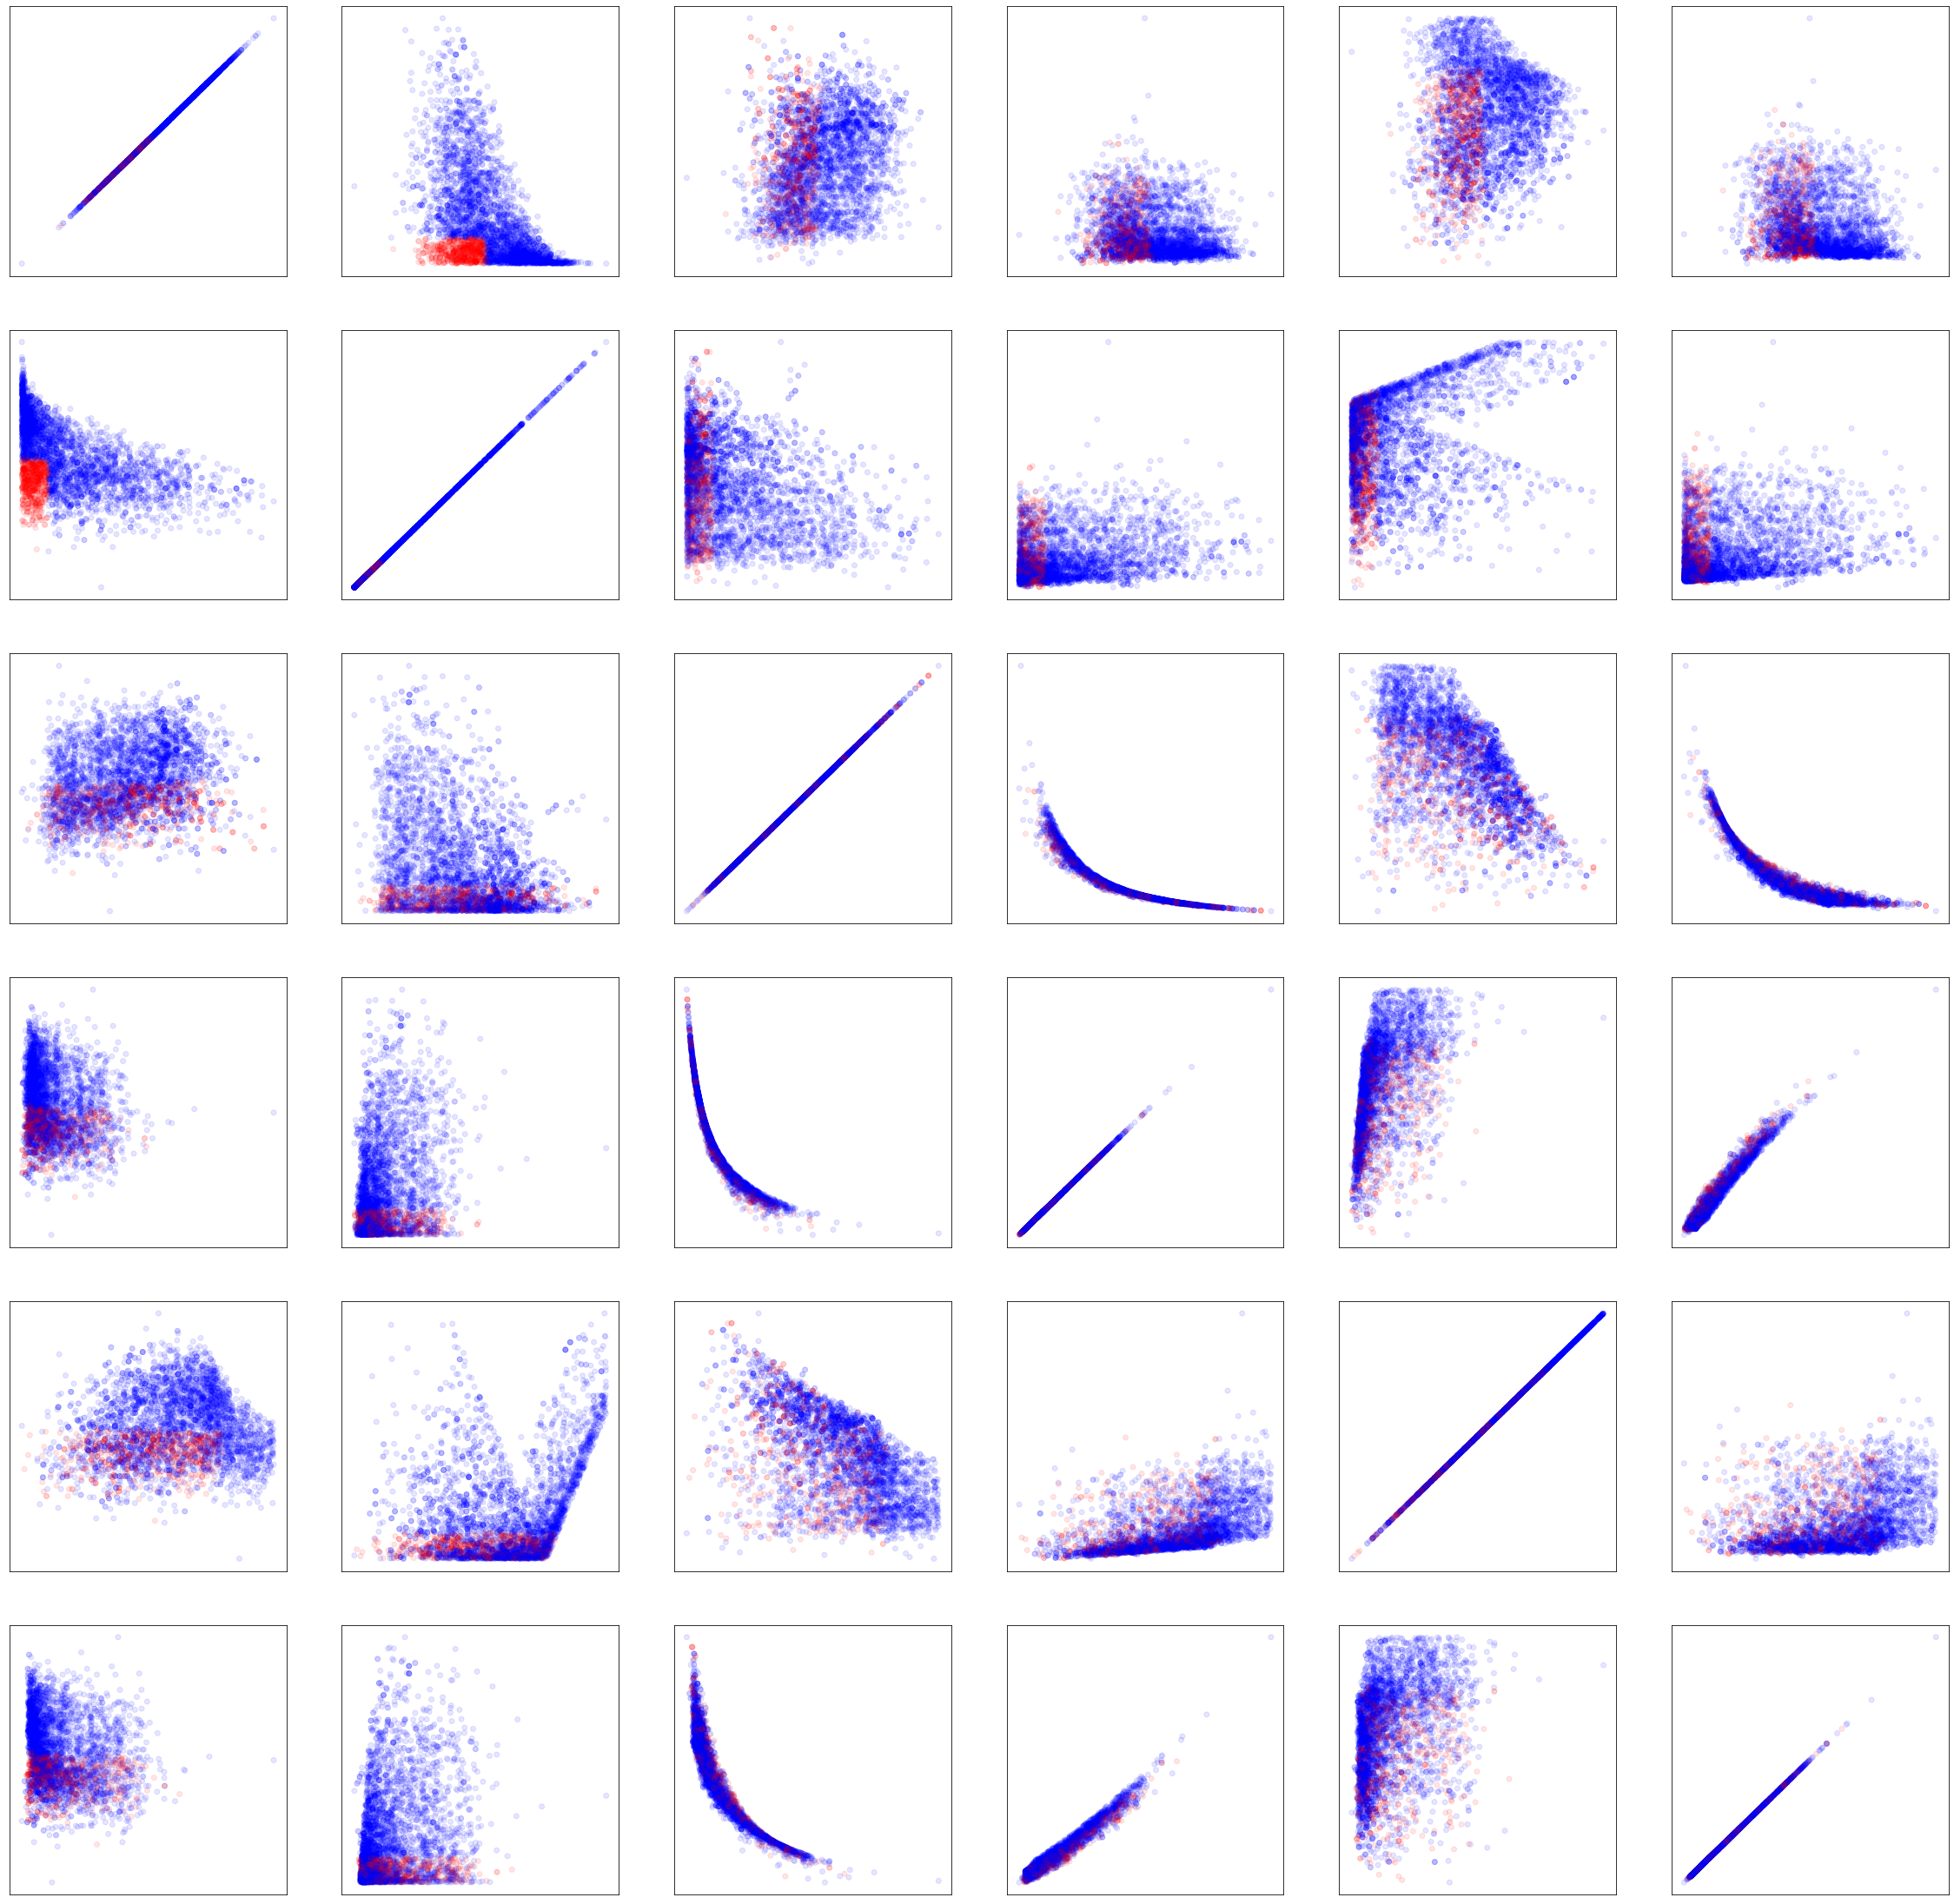

In [41]:
fig = plt.figure(figsize=(40,40))

k = 1

ycolors = ['r' if value > 0 else 'b' for value in y_pre]

for i in range(X_final_pre.shape[1]):
    for j in range(X_final_pre.shape[1]):
        fig.add_subplot(X_final_pre.shape[1],X_final_pre.shape[1], k)
        plt.scatter(X_final_pre[:,i],X_final_pre[:,j],color=ycolors, marker='o', alpha=0.1)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        k = k + 1